# Recession Probability Calculator with plots
## Using Treasury Spreads, SPX and VIX

The goal of this notebook is to test if treasury spreads 10Y-2Y, 10Y-3M along with SPX and VIX are successful in indicating impending economic recession. 
This concept is based on paper:
https://www.frbsf.org/economic-research/publications/economic-letter/2018/march/economic-forecasts-with-yield-curve/


In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

import os
#os.getcwd()

%matplotlib inline
rcParams['figure.figsize']=15,12
sb.set_style('whitegrid')

# Load Data Sets

## Load recession indicator data

The data sources are as below:
ecession Data:

https://fred.stlouisfed.org/series/USREC

Treasury 10Y-2Y

https://fred.stlouisfed.org/series/T10Y2Y

Treasury 10Y-3M

https://fred.stlouisfed.org/series/T10Y3M

SP500

https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1609545600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

VIX

https://finance.yahoo.com/quote/%5EVIX/history?period1=631238400&period2=1609545600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [11]:
dfRec = pd.read_csv("./USREC_Jan2021.csv")
dfRec.head() #note data is monthly
print(dfRec.dtypes) #Check Data Type of columns
dfRec['DT'] = pd.to_datetime(dfRec['DATE'], format='%Y-%m-%d') #convert date from string to datetime
print("\n DATE obj--->DT datetime \n")
print(dfRec.dtypes) #Recheck
dfRec = dfRec.drop('DATE',axis=1) #drop the original DATE column
dfRec=dfRec.set_index('DT')#set index to new datetime dt

start_date = dfRec.index.min() - pd.DateOffset(day=1)
end_date = dfRec.index.max() + pd.DateOffset(month=2)+pd.DateOffset(day=31) 
#Pad end date by 2 months - assume last month data continues for 1 extra month, 
#this helps with using latest data from X variables
print("END DATE:")
print(end_date)
dates = pd.date_range(start_date, end_date, freq='D') #create dates between a date range
dates.name = 'date'
dfRec = dfRec.reindex(dates, method='ffill') #reindex to new dates and forward fill. 
dfRec.tail(5)


DATE     object
USREC     int64
dtype: object

 DATE obj--->DT datetime 

DATE             object
USREC             int64
DT       datetime64[ns]
dtype: object
END DATE:
2021-02-28 00:00:00


,USREC
date,
2021-02-24,1
2021-02-25,1
2021-02-26,1
2021-02-27,1
2021-02-28,1


## Load Treasury, SPX, VIX data

In [12]:

def extractStLouisData(Name):
    header = Name.split('.')[0]
    df10y2y=pd.read_csv(Name)

    df10y2y['DT'] = pd.to_datetime(df10y2y['DATE'], format='%Y-%m-%d')
    df10y2y = df10y2y.drop('DATE',axis=1)
    df10y2y = df10y2y.set_index('DT')
    df10y2y[header] = pd.to_numeric(df10y2y[header],errors='coerce')
    if df10y2y[header].isnull().values.any(): #check if there are any nan values
    #df10y2y['T10Y2Y'].index[df10y2y['T10Y2Y'].apply(np.isnan)] check index where nan. 
        df10y2y = df10y2y.dropna(subset=[header])
    display(df10y2y.head())
    return df10y2y

def extractYahooData(Name):
    header = Name.split('.')[0]
    dfx = pd.read_csv(Name)
    dfx['DT'] = pd.to_datetime(dfx['Date'], format='%Y-%m-%d')
    dfx = dfx.drop(['Date','Open','High','Low','Close','Volume'],axis=1)
    dfx = dfx.set_index('DT')
    dfx['Adj Close'].isnull().values.any()
    dfx=dfx.rename(columns={'Adj Close':header})
    display(dfx.tail())
    return dfx    

#10Y-2Y
df10y2y = extractStLouisData('T10Y2Y.csv')
#10Y-3M
df10y3m=extractStLouisData('T10Y3M.csv')
#SPX
dfspx = extractYahooData('SP500.csv')
#VIX
dfvix = extractYahooData('VIX.csv')



,T10Y2Y
DT,
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79


,T10Y3M
DT,
1982-01-04,2.32
1982-01-05,2.24
1982-01-06,2.43
1982-01-07,2.46
1982-01-08,2.50


,SP500
DT,
2021-02-11,3916.379883
2021-02-12,3934.830078
2021-02-16,3932.590088
2021-02-17,3931.330078
2021-02-18,3913.969971


,VIX
DT,
2021-02-11,21.250000
2021-02-12,19.969999
2021-02-16,21.459999
2021-02-17,21.500000
2021-02-18,22.490000


# Merge DataFrames on Index

In [13]:
#df = dfRec.merge(df10y2y,left_index=True,right_index=True)
df = pd.concat([dfRec,df10y2y,df10y3m,dfspx,dfvix],axis=1,join='inner')

In [14]:
df.tail()

,USREC,T10Y2Y,T10Y3M,SP500,VIX
2021-02-11,1,1.05,1.11,3916.379883,21.250000
2021-02-12,1,1.09,1.16,3934.830078,19.969999
2021-02-16,1,1.17,1.26,3932.590088,21.459999
2021-02-17,1,1.18,1.25,3931.330078,21.500000
2021-02-18,1,1.18,1.26,3913.969971,22.490000


In [15]:
df.isnull().values.any()

False

## Standardize the input variable data

In [16]:
Xdf = df[['T10Y2Y','T10Y3M','SP500','VIX']]
Ydf =df[['USREC']]
scaler = StandardScaler()
XdfStd = pd.DataFrame(scaler.fit_transform(Xdf),columns=Xdf.columns,index=Xdf.index)
XdfStd.head()

,T10Y2Y,T10Y3M,SP500,VIX
1990-01-02,-1.226515,-1.389501,-1.285613,-0.276989
1990-01-03,-1.249375,-1.398291,-1.286831,-0.159562
1990-01-04,-1.237945,-1.363132,-1.290880,-0.032246
1990-01-05,-1.203655,-1.310392,-1.295426,0.077765
1990-01-08,-1.169365,-1.284022,-1.293343,0.096306


# Explore Data

In [17]:
df['USREC'].value_counts()

0    6832
1     946
Name: USREC, dtype: int64

In [18]:
XdfStd.describe()

,T10Y2Y,T10Y3M,SP500,VIX
count,7.778000e+03,7.778000e+03,7.778000e+03,7.778000e+03
mean,-1.649669e-16,6.529947e-16,-1.716407e-15,-2.031603e-16
std,1.000064e+00,1.000064e+00,1.000064e+00,1.000064e+00
min,-1.900888e+00,-2.321231e+00,-1.369762e+00,-1.278209e+00
25%,-9.293342e-01,-8.357372e-01,-6.536828e-01,-7.195033e-01
50%,-7.208071e-02,-2.706586e-02,-1.669205e-01,-2.429968e-01
75%,8.651831e-01,8.255550e-01,3.361790e-01,4.213929e-01
max,2.019618e+00,1.915503e+00,3.398253e+00,7.813116e+00


In [19]:
XdfStd.corr()

,T10Y2Y,T10Y3M,SP500,VIX
T10Y2Y,1.000000,0.924956,-0.219585,0.093454
T10Y3M,0.924956,1.000000,-0.360810,0.041266
SP500,-0.219585,-0.360810,1.000000,-0.068849
VIX,0.093454,0.041266,-0.068849,1.000000


<AxesSubplot:xlabel='USREC', ylabel='count'>

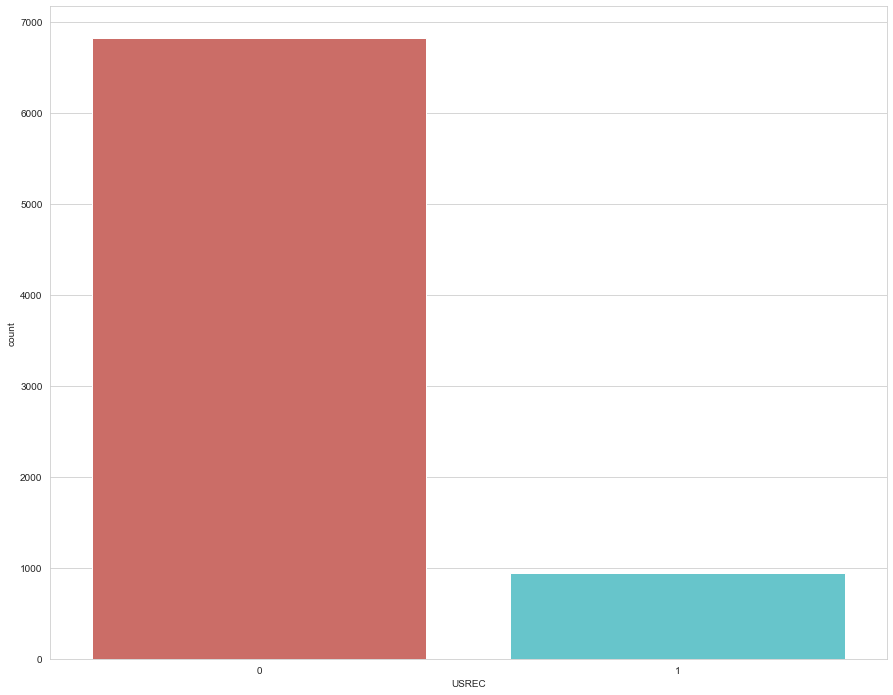

In [20]:
sb.countplot(x='USREC',data=df,palette='hls')

## Percentage of days in recession

In [21]:
df['USREC'].value_counts()/len(df) 

0    0.878375
1    0.121625
Name: USREC, dtype: float64

In [22]:
df['recBoundaries'] = df['USREC'].diff()

In [23]:
recessionBegin= df[df['recBoundaries']==1].index.tolist() #Dates when recession begins
recessionEnd = df[df['recBoundaries']==-1].index.tolist() #Dates when recession ends
#If all recessions are in the past then start and end date vectors will be of same length
#Unless there is a current recession in progress and the end date is in future. 

if(len(recessionBegin)>len(recessionEnd)): #if recession is still in progress append last available date to recessionEnd
    t = df.iloc[[-1]].index.tolist()[0]
    recessionEnd.append(t)
recessionStartEndDates = zip(recessionBegin,recessionEnd)
x=list(recessionStartEndDates)
recessionBounds = np.array(x)

[Timestamp('1990-08-01 00:00:00') Timestamp('1991-04-01 00:00:00')]
[Timestamp('2001-04-02 00:00:00') Timestamp('2001-12-03 00:00:00')]
[Timestamp('2008-01-02 00:00:00') Timestamp('2009-07-01 00:00:00')]
[Timestamp('2020-03-02 00:00:00') Timestamp('2021-02-18 00:00:00')]


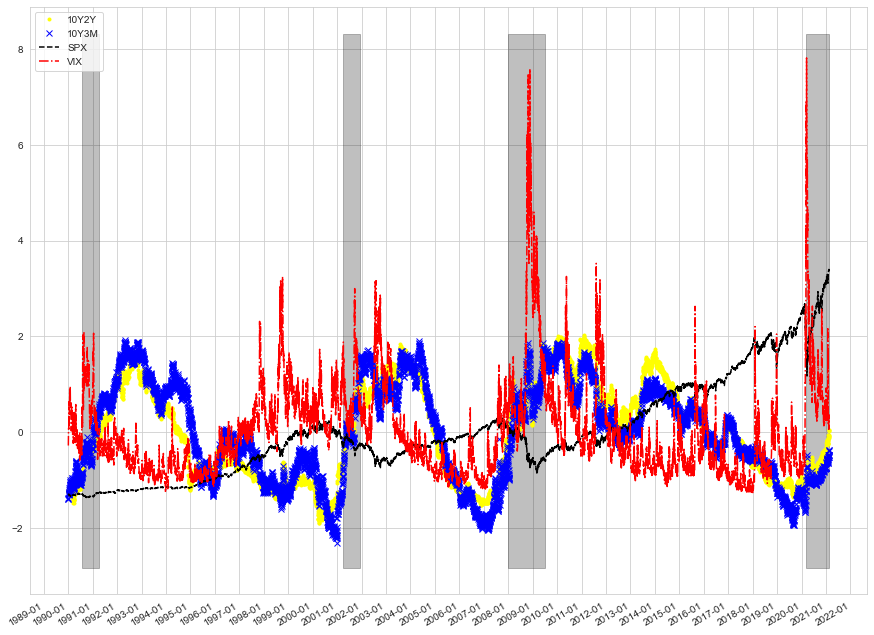

In [24]:
#rcParams['figure.figsize']=18,16
fig,ax = plt.subplots()
dates = df.index
#print(dates[-1])
ax.plot_date(dates,XdfStd['T10Y2Y'],'.',scaley=True,color='yellow',label='10Y2Y')
ax.plot_date(dates,XdfStd['T10Y3M'],'x',scaley=True,color='blue',label='10Y3M')
ax.plot_date(dates,XdfStd['SP500'],'--',scaley=True,color='black',label='SPX')
ax.plot_date(dates,XdfStd['VIX'],'-.',scaley=True,color='red',label='VIX')

ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_xlim(df.iloc[[0]].index.tolist()[0],df.iloc[[-1]].index.tolist()[0])

y1,y2 = ax.get_ylim()
for row in recessionBounds:
    print(row)
    ax.fill_between(row,y1,y2,alpha=0.25,color='k')
ax.legend()
fig.autofmt_xdate()
plt.show()

# Modeling Strategy

* Based on the graph above, we observe that 10Y2Y and 10Y3M spreads attain their local minima a few months prior to the recession, so for now we manually chose the lag to be 6m (180days) on all feature variables, later we will use a grid search to find the optimized lag. It also makes modelings sense to introduce lags in x-variables as we want some future prediction capability in our model. i.e if we have today's data we should be able to predict probability of recession 6months ahead. 

* We will create test and train test based on stratification on the recession indicator variable - because out of all the data we are in recession only 12% of time. Thus the training split should indicate the same split. 

* Use Logistic Regression - only on training data

* Our regression equation will be of form y(t) = a*[X(t-6M)] +[C]

* Evaluate Regression on test data



In [25]:
XdfStdLagged = XdfStd.shift(periods=180,freq='D') 
#Since freq='D' is specified the index will be shifted and no NaN values created
XdfStdLagged.head()
XYdf = pd.concat([Ydf,XdfStdLagged],axis=1,join='inner')
display(XYdf.head())
display(XYdf.tail())
#confirm the shift
print(XdfStd.loc['1990-01-03'])
print("\n After Lag:\n")
print(XYdf.loc['1990-07-02'])

XYdf.isnull().values.any() #Check if there are any null values in the data set. 

,USREC,T10Y2Y,T10Y3M,SP500,VIX
1990-07-02,0,-1.249375,-1.398291,-1.286831,-0.159562
1990-07-03,0,-1.237945,-1.363132,-1.290880,-0.032246
1990-07-09,0,-1.169365,-1.240073,-1.301832,0.365770
1990-07-10,0,-1.157935,-1.275233,-1.300234,0.070348
1990-07-11,0,-1.112215,-1.169754,-1.311501,0.637706


,USREC,T10Y2Y,T10Y3M,SP500,VIX
2021-02-08,1,-0.700733,-0.976376,2.671817,0.345993
2021-02-09,1,-0.677873,-0.950006,2.662751,0.327451
2021-02-10,1,-0.655013,-0.950006,2.661991,0.317563
2021-02-16,1,-0.712163,-1.011535,2.678577,0.400380
2021-02-17,1,-0.757883,-1.011535,2.693840,0.378131


T10Y2Y   -1.249375
T10Y3M   -1.398291
SP500    -1.286831
VIX      -0.159562
Name: 1990-01-03 00:00:00, dtype: float64

 After Lag:

USREC     0.000000
T10Y2Y   -1.249375
T10Y3M   -1.398291
SP500    -1.286831
VIX      -0.159562
Name: 1990-07-02 00:00:00, dtype: float64


False

In [26]:
XYdf["USREC"].value_counts()/len(XYdf) #Check recession days split again

0    0.875789
1    0.124211
Name: USREC, dtype: float64

In [27]:

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=42)
for train_indx,test_indx in split.split(XYdf,XYdf['USREC']):
    strat_train_set = XYdf.iloc[train_indx]
    strat_test_set = XYdf.iloc[test_indx]
    

In [28]:
strat_train_set['USREC'].value_counts()/len(strat_train_set) #Check recession days split in training data

0    0.875684
1    0.124316
Name: USREC, dtype: float64

In [29]:
strat_test_set['USREC'].value_counts()/len(strat_test_set)

0    0.876033
1    0.123967
Name: USREC, dtype: float64

In [30]:
LR = LogisticRegression(class_weight='balanced')
Xtrain = strat_train_set.loc[:,strat_train_set.columns!='USREC'].values
Ytrain = strat_train_set.loc[:,strat_train_set.columns=='USREC'].values.ravel()

Xtest = strat_test_set.loc[:,strat_test_set.columns!='USREC'].values
Ytest = strat_test_set.loc[:,strat_test_set.columns=='USREC'].values.ravel()

LR.fit(Xtrain,Ytrain)
Ypred = LR.predict(Xtest)
print("Accuracy of classifier on test set:{:.2f}\n\n".format(LR.score(Xtest,Ytest)))
print(classification_report(Ytest,Ypred))

Accuracy of classifier on test set:0.75


              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1166
           1       0.29      0.74      0.42       165

    accuracy                           0.75      1331
   macro avg       0.62      0.74      0.63      1331
weighted avg       0.87      0.75      0.79      1331



# Plot the porbability of recession
The probability prediction dates are to be indexed to the lagged standardized X (feature/independent) variables
This also allows us to predict probability 6months in future, as our model uses 6 months lagged data.
We also conduct EWMA smoothing over the probability with com = 9.5, resulting in alpha=0.1, 1-alpha = 0.90.
alpha=1/(1+com)
weighted_average[i] = (1-alpha)*weighted_average[i-1] + alpha*arg[i]

However, to plot the SPX data on same plot we make sure to use the correct date indices of the realized data. 


In [31]:
XlaggedFullArray = XdfStdLagged.values
recessionProbability = LR.predict_proba(XlaggedFullArray)[:,1]
probDf = pd.DataFrame(recessionProbability,columns=['RecProb'],index=XdfStdLagged.index)
probDf['ewma'] = probDf['RecProb'].ewm(com=9.5).mean() #20-day EWMA, 
probDf.tail()


,RecProb,ewma
2021-08-10,0.761062,0.809814
2021-08-11,0.718711,0.801138
2021-08-15,0.741792,0.795486
2021-08-16,0.747096,0.790877
2021-08-17,0.768868,0.788781


[Timestamp('1990-08-01 00:00:00') Timestamp('1991-04-01 00:00:00')]
[Timestamp('2001-04-02 00:00:00') Timestamp('2001-12-03 00:00:00')]
[Timestamp('2008-01-02 00:00:00') Timestamp('2009-07-01 00:00:00')]
[Timestamp('2020-03-02 00:00:00') Timestamp('2021-02-18 00:00:00')]


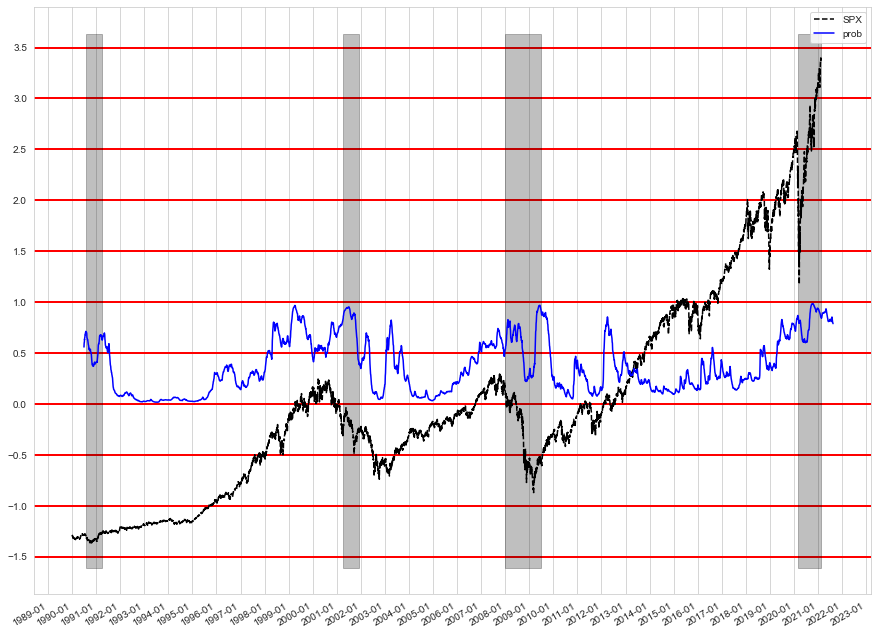

In [32]:
fig,ax = plt.subplots()
dates = probDf.index
#ax.plot_date(XdfStd.index,XdfStd['T10Y2Y'],'.',scaley=True,color='yellow',label='10Y2Y')
#ax.plot_date(dates,XdfStd['T10Y3M'],'x',scaley=True,color='blue',label='10Y3M')
ax.plot_date(XdfStd.index,XdfStd['SP500'],'--',scaley=True,color='black',label='SPX')
#ax.plot_date(dates,XdfStd['VIX'],'-.',scaley=True,color='red',label='VIX')
ax.plot_date(dates,probDf['ewma'],'-',scaley=True,color='blue',label='prob')

ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_xlim(df.iloc[[0]].index.tolist()[0],df.iloc[[-1]].index.tolist()[0])
majorloc=plticker.MultipleLocator(base=0.5)
ax.yaxis.set_major_locator(majorloc)
minorloc=plticker.MultipleLocator(base=0.1)
ax.yaxis.set_minor_locator(minorloc)

y1,y2 = ax.get_ylim()
for row in recessionBounds:
    print(row)
    ax.fill_between(row,y1,y2,alpha=0.25,color='k')
ax.legend()
fig.autofmt_xdate()
ax.grid(b=True,which='major',axis='y',color='r',linewidth=2)
plt.show()

0.7444825614636935


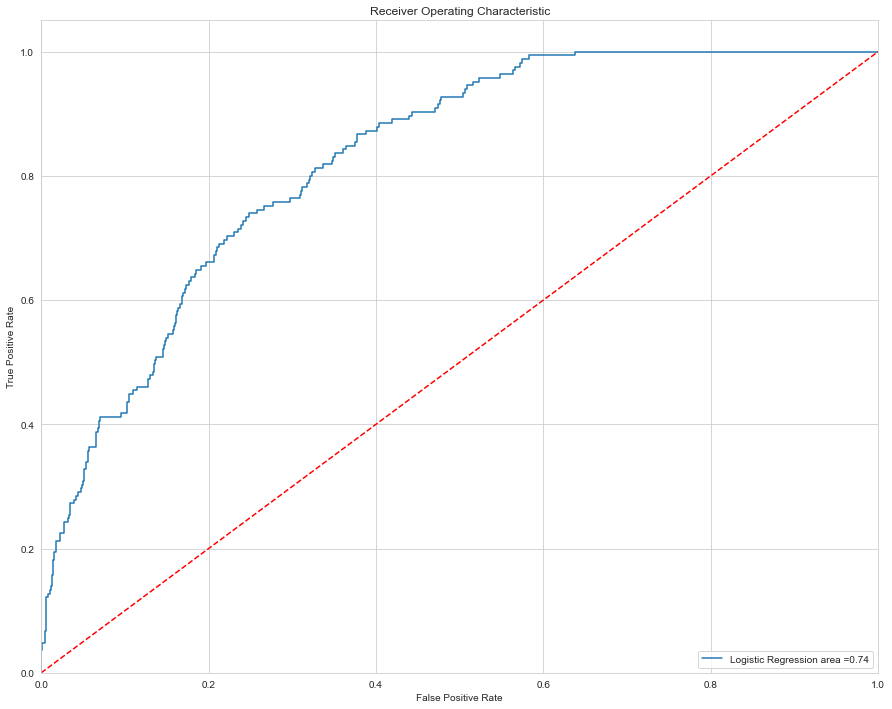

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(Ytest,LR.predict(Xtest))
print(roc_auc)
fpr,tpr,thresholds = roc_curve(Ytest,LR.predict_proba(Xtest)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression area ={:.2f}'.format(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()